In [98]:
# Python code to build Machine Learning model for hurricane intensity forecast  
import pandas as pd # For data manipulation and analysis
pd.set_option('display.max_columns', 500)
import numpy as np # For scientific computing

#Machine Learning Tools
import sklearn # For machine learning library
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

#from sklearn.ensemble import ExtraTreesClassifier    # Extra tree classifier
from sklearn.metrics import confusion_matrix # Compute confusion matrix to evaluate the accuracy of a classification.
from sklearn.metrics import brier_score_loss  # Compute the Brier score
from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import brier_score_loss  # Compute the Brier score


import matplotlib.pyplot as plt  #plotting library


from imblearn.over_sampling import SMOTE #SMOTE oversampling

#Displaying More Rows
pd.options.display.max_rows = 500

In [99]:
#====================================
#Read SHIPS spread-sheet data
#====================================
# Set up the location of the SHIPS data
fname='Dataset_SHIPS_RII_ATL.csv'
#fname='Dataset_SHIPS_RII_EPAC.csv'

# Read SHIPS data
ships = pd.read_csv(fname)
ships.head()

,NAME,DATE,HOUR,VMX0,LAT,LON,MSLP,ID,DELV12,DELV24,DELV36,DELV48,PER,SHRD,D200,RHLO,PX30,SDBT,POT,OHC,TPW,PC2,U200,TPWC,AVBT,RSST
0,ALEX,980727,12,25,11.3,-25.4,1009,AL011998,0,5,10,10,9999,6.3,103,68,72,13.8,-101,12,0,-58,-7.9,55.7,-473,27.4
1,ALEX,980727,18,25,11.7,-27.2,1009,AL011998,0,5,10,10,9999,11.2,118,69,55,12.6,-102,17,0,-10,-6.4,55.7,-360,27.4
2,ALEX,980728,0,25,12.2,-29.2,1009,AL011998,5,10,10,10,0,8.6,116,71,70,12.8,-105,21,0,-3,-8.8,56.9,-381,27.4
3,ALEX,980728,6,25,12.6,-31.3,1008,AL011998,5,10,10,15,0,12.2,91,71,57,12.2,-100,29,0,-44,-6.0,52.7,-481,27.2
4,ALEX,980728,12,30,12.9,-33.3,1007,AL011998,5,5,5,10,5,10.5,88,71,83,10.1,-89,15,190,-46,-6.5,55.3,-516,27.1


In [100]:
#================================
# Set up parameters
#================================
# Year range for training and validating
year_train=['1998','2008']

# Year range for forecast
year_fcst=['2009','2017']

# Variable name for predictand
TargetName='DELV24'

# Threshold of Rapid Intensification 
RIValue=30

# Climatology of RI (30 kt) frequency at Atlantic basin (Kaplan et al. 2015)
clim=0.125   #ATL 30 kt
#clim=0.084   #EPAC 30 kt

In [101]:
#================================
# Data pre-processing
#================================
# Set all 9999s as NaNs
ships = ships.replace(9999,np.NaN)

# drop NaNs
ships=ships.dropna()

# Pad the date columns with 00 for the year 2000
ships['DATE'] = ships['DATE'].apply(lambda x: str(x).zfill(6))

# Extract month from date
ships['MONTH'] = ships['DATE'].apply(lambda x: str(x)[2:4])

# Extract year from date
ships['YEAR'] = ships['DATE'].apply(lambda x: ('19' + str(x)[0:2]) if (str(x)[0:1]!= '0' and str(x)[0:1]!= '1') else ('20' + str(x)[0:2]))
ships.head()

# Set the target column
ships['TAR'] = ships[TargetName].apply(lambda x: 1 if x >= RIValue else 0)
ships

,NAME,DATE,HOUR,VMX0,LAT,LON,MSLP,ID,DELV12,DELV24,DELV36,DELV48,PER,SHRD,D200,RHLO,PX30,SDBT,POT,OHC,TPW,PC2,U200,TPWC,AVBT,RSST,MONTH,YEAR,TAR
2,ALEX,980728,0,25,12.2,-29.2,1009,AL011998,5.0,10.0,10.0,10.0,0.0,8.6,116,71,70.0,12.8,-105,21.0,0,-3.0,-8.8,56.9,-381.0,27.4,07,1998,0
3,ALEX,980728,6,25,12.6,-31.3,1008,AL011998,5.0,10.0,10.0,15.0,0.0,12.2,91,71,57.0,12.2,-100,29.0,0,-44.0,-6.0,52.7,-481.0,27.2,07,1998,0
4,ALEX,980728,12,30,12.9,-33.3,1007,AL011998,5.0,5.0,5.0,10.0,5.0,10.5,88,71,83.0,10.1,-89,15.0,190,-46.0,-6.5,55.3,-516.0,27.1,07,1998,0
5,ALEX,980728,18,30,13.1,-35.1,1006,AL011998,5.0,5.0,10.0,15.0,5.0,9.7,44,72,35.0,15.9,-86,22.0,15,36.0,-7.2,56.6,-270.0,27.1,07,1998,0
6,ALEX,980729,0,35,13.3,-36.8,1005,AL011998,0.0,0.0,5.0,10.0,5.0,9.9,37,74,56.0,14.5,-80,24.0,0,-6.0,-10.3,57.7,-443.0,27.1,07,1998,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7379,OPHE,171013,18,80,32.0,-32.5,973,AL172017,15.0,20.0,10.0,0.0,-10.0,9.7,5,62,45.0,12.2,-24,0.0,580,24.0,24.0,52.5,-349.0,26.0,10,2017,0
7393,RINA,171106,6,30,29.0,-50.7,1010,AL192017,0.0,10.0,10.0,20.0,0.0,14.8,14,67,33.0,29.4,-94,1.0,864,118.0,18.0,45.7,-159.0,26.2,11,2017,0
7394,RINA,171106,12,30,29.1,-50.4,1010,AL192017,5.0,10.0,15.0,15.0,0.0,14.3,5,66,28.0,26.2,-93,0.0,934,126.0,16.2,46.6,-106.0,26.1,11,2017,0
7395,RINA,171106,18,30,29.4,-50.2,1009,AL192017,10.0,10.0,20.0,15.0,0.0,18.8,3,65,27.0,24.5,-90,0.0,895,138.0,18.0,46.0,-57.0,25.9,11,2017,0


In [102]:

# Variable names for predictors
Predictor_Sets=[]

# Adding different machine learning models into the list
Predictor_Sets.append(('Set1', ['PER','SHRD','D200','TPW','PC2','SDBT','POT','OHC','VMX0']))
Predictor_Sets.append(('Set2', ['PER','SHRD','D200','TPW','PC2','POT','OHC','VMX0']))
Predictor_Sets.append(('Set3', ['PER','SHRD','D200','TPW','SDBT','POT','OHC','VMX0']))
Predictor_Sets.append(('Kaplan 2015', ['PER','SHRD','D200','RHLO','PX30','SDBT','POT','OHC']))
Predictor_Sets.append(('Kaplan 2015 Imp', ['PER','SHRD','D200','TPW','PC2','SDBT','POT','OHC','VMX0'])) #ICDA didn't exist in the dataset

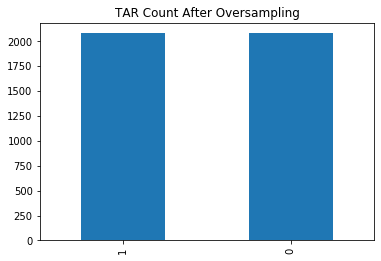

In [103]:
Data_Sets=[]

# Data Set 1: Sampling All
### Dividing Data into two by year
data_train_by_year = ships[(ships['YEAR']>=year_train[0]) & (ships['YEAR']<=year_train[1])]
data_fcst_by_year = ships[(ships['YEAR']>=year_fcst[0]) & (ships['YEAR']<=year_fcst[1])]

TAR_0 = data_train_by_year[data_train_by_year['TAR']==0]
TAR_1 = data_train_by_year[data_train_by_year['TAR']==1]

TAR_0_count_train,TAR_1_count_train=data_train_by_year['TAR'].value_counts()

# Data Set 2: Under-Sampling
### Undersampling RI=0 Rows

TAR_0_under=TAR_0.sample(TAR_1_count_train)
data_train_under = pd.concat([TAR_0_under,TAR_1], axis=0)

data_train_under['TAR'].value_counts().plot(kind='bar', title='count (target)')

# Data Set 3: Over-Sampling
### Undersampling RI=1 Rows

TAR_1_over=TAR_1.sample(TAR_0_count_train,replace=True)
data_train_over = pd.concat([TAR_0,TAR_1_over], axis=0)

data_train_over['TAR'].value_counts().plot(kind='bar', title='count (target)')
plt.title('TAR Count After Oversampling')


# Data Set 4: Normalized

def normalization(data,column_names):
    data_nur=data[column_names]
    data_nur=(data_nur-data_nur.mean())/(data_nur.std()) #standard normal distribution
    data[column_names]=data_nur[column_names]
    return data

### Applying function above to numerical features
num_col=['VMX0','PER','SHRD','D200','RHLO','PX30','SDBT','POT','OHC','TPW','PC2','U200','TPWC','AVBT','RSST']
ships_nor=normalization(ships,num_col)

data_train_nor = ships_nor[(ships_nor['YEAR']>=year_train[0]) & (ships_nor['YEAR']<=year_train[1])]
data_fcst_nor = ships_nor[(ships_nor['YEAR']>=year_fcst[0]) & (ships_nor['YEAR']<=year_fcst[1])]


TAR_0_nor = data_train_nor[data_train_nor['TAR']==0]
TAR_1_nor = data_train_nor[data_train_nor['TAR']==1]

# Data Set 5: Under-Sampling (Normalized)
### Undersampling RI=0 Rows

TAR_0_under_nor=TAR_0_nor.sample(TAR_1_count_train)
data_train_under_nor = pd.concat([TAR_0_under_nor,TAR_1_nor], axis=0)

# Data Set 6: Over-Sampling (Normalized)
### Undersampling RI=1 Rows

TAR_1_over_nor=TAR_1_nor.sample(TAR_0_count_train,replace=True)
data_train_over_nor = pd.concat([TAR_0_nor,TAR_1_over_nor], axis=0)



# Adding newly created data into a series
Data_Sets.append(('By Year', data_train_by_year,data_fcst_by_year))
Data_Sets.append(('Undersample', data_train_under,data_fcst_by_year))
Data_Sets.append(('Oversample', data_train_over,data_fcst_by_year))
Data_Sets.append(('Normalized', data_train_nor,data_fcst_nor))
Data_Sets.append(('Undersample (Normalized)', data_train_under_nor,data_fcst_by_year))
Data_Sets.append(('Oversample (Normalized)', data_train_over_nor,data_fcst_by_year))


In [104]:
data_fcst_nor

,NAME,DATE,HOUR,VMX0,LAT,LON,MSLP,ID,DELV12,DELV24,DELV36,DELV48,PER,SHRD,D200,RHLO,PX30,SDBT,POT,OHC,TPW,PC2,U200,TPWC,AVBT,RSST,MONTH,YEAR,TAR
4489,BILL,090815,18,-1.032871,11.2,-34.5,1004,AL032009,5.0,20.0,30.0,45.0,0.127474,-0.367757,-1.978362,1.313188,-0.557732,0.054042,-0.739833,-0.648851,-0.626043,0.160641,-1.984346,0.524722,0.425423,-0.198957,08,2009,0
4490,BILL,090816,0,-1.032871,11.2,-35.5,1004,AL032009,15.0,25.0,40.0,50.0,0.127474,-0.561105,-1.359290,1.313188,-0.631034,0.313634,-0.739833,-0.845529,-0.626043,-0.241931,-1.874345,0.454018,-0.152894,-0.269324,08,2009,0
4491,BILL,090816,6,-0.856830,11.5,-36.5,1002,AL032009,15.0,25.0,40.0,50.0,0.127474,-0.799947,-0.482270,1.173271,0.541791,0.529961,-0.588660,-0.779970,-0.626043,-0.753308,-1.595109,0.524722,-0.627410,-0.269324,08,2009,0
4492,BILL,090816,12,-0.504748,12.0,-37.8,997,AL032009,10.0,25.0,35.0,45.0,1.149174,-1.345871,-0.301708,1.033355,0.395188,0.270369,-0.346782,-0.517732,-0.626043,-0.448658,-1.408953,0.567144,-0.113351,-0.269324,08,2009,0
4493,BILL,090816,18,-0.328707,12.6,-39.4,994,AL032009,10.0,25.0,35.0,45.0,1.149174,-1.129776,0.472133,1.173271,1.164854,-0.854530,-0.044435,-0.517732,-0.626043,-0.992675,-1.146641,0.736833,-0.810297,-0.339692,08,2009,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7379,OPHE,171013,18,0.551498,32.0,-32.5,973,AL172017,15.0,20.0,10.0,0.0,-1.405076,-0.504238,-0.714422,-0.925474,-0.667685,-0.508407,1.316126,-1.238886,1.337704,0.465291,1.696480,-0.960054,0.282080,-1.535935,10,2017,0
7393,RINA,171106,6,-1.208912,29.0,-50.7,1010,AL192017,0.0,10.0,10.0,20.0,-0.383376,0.075807,-0.482270,-0.225892,-1.107494,1.972138,-0.800303,-1.206106,2.299263,1.488043,1.188780,-1.921624,1.221227,-1.395201,11,2017,0
7394,RINA,171106,12,-1.208912,29.1,-50.4,1010,AL192017,5.0,10.0,15.0,15.0,-0.383376,0.018939,-0.714422,-0.365809,-1.290748,1.510641,-0.770068,-1.238886,2.536266,1.575086,1.036470,-1.794357,1.483200,-1.465568,11,2017,0
7395,RINA,171106,18,-1.208912,29.4,-50.2,1009,AL192017,10.0,10.0,20.0,15.0,-0.383376,0.530743,-0.766012,-0.505725,-1.327399,1.265471,-0.679364,-1.238886,2.404221,1.705650,1.188780,-1.879201,1.725401,-1.606303,11,2017,0


In [105]:
# Creating an empty list
Models = []

# Adding different machine learning models into the list
Models.append(('Logistic_Regression', LogisticRegression(solver='liblinear', multi_class='ovr')))
Models.append(('K_Neighbors_Classifier', KNeighborsClassifier(n_neighbors=15)))
Models.append(('Decision_Tree', DecisionTreeClassifier(random_state=1,min_samples_split=10,max_depth=5)))
Models.append(('Random_Forest', RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=66, max_depth=6, min_samples_leaf=2, class_weight='balanced')))
Models.append(('Neural_Network_Logistic', MLPClassifier((10,10), activation='logistic',max_iter=3000)))
Models.append(('Neural_Network_ReLU', MLPClassifier((10,10), activation='relu',max_iter=3000)))

In [106]:
def ML_Calc(predictors,data_sets,models,target):
   
    results=pd.DataFrame()

    for name_pred,features in predictors:
        for name_data,data_train,data_fcst in data_sets:
        # All predictors for training and validating
            XData_train = data_train[features]
            YData_train = data_train[target]

            # All predictors for training and validating
            XData_fcst = data_fcst[features]
            YData_fcst = data_fcst[target]
            # For loop will iterate through each models in 'models' list
            for name_ML, model in models:
                model.fit(XData_train,YData_train)
                prediction_train=model.predict(XData_train)
                prediction_fcst=model.predict(XData_fcst)
                
                #P erformance Metrics
                cmatrix_fcst = confusion_matrix(YData_fcst, prediction_fcst)
                
                false_neg=cmatrix_fcst[1,0]
                false_pos=cmatrix_fcst[0,1]
                true_pos=cmatrix_fcst[1,1]
                true_neg=cmatrix_fcst[0,0]
                
                pss=((cmatrix_fcst[0,0] * cmatrix_fcst[1,1]) - (cmatrix_fcst[0,1] * cmatrix_fcst[1,0])) * 1.0 / ((cmatrix_fcst[1,1] + cmatrix_fcst[1,0]) * (cmatrix_fcst[0,1] + cmatrix_fcst[0,0]))
                far=(cmatrix_fcst[0,1] * 1.0) / (cmatrix_fcst[0,1] + cmatrix_fcst[1,1])
                pod=(cmatrix_fcst[1,1] * 1.0) / (cmatrix_fcst[1,0] + cmatrix_fcst[1,1]) 
                precision=precision_score(YData_fcst, prediction_fcst, average=None)[1]
                recall=recall_score(YData_fcst, prediction_fcst)
                f1=f1_score(YData_fcst, prediction_fcst)
                brier_score=brier_score_loss(YData_fcst,prediction_fcst)
                
                results=results.append({"Predictor Set":name_pred,"Data Set":name_data, 
                                        "ML Name":name_ML,"False Negative":false_neg,"False Positive":false_pos,
                                        "PSS":pss,"FAR":far,"POD":pod, "Recall":recall,"Precision":precision,"F1":f1, 
                                        "Brier Score":brier_score}, 
                                       ignore_index = True) 




    results=results[["Data Set","Predictor Set", "ML Name","False Negative",
                     "False Positive","PSS","FAR","POD","F1","Precision","Brier Score"]]
    results=results.sort_values('False Negative')
    return results


In [107]:
Result=ML_Calc(Predictor_Sets,Data_Sets,Models,'TAR')

C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\kwonk\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\kwonk\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\

C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\kwonk\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\kwonk\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\

In [108]:
Result.sort_values('PSS',ascending=False)

,Data Set,Predictor Set,ML Name,False Negative,False Positive,PSS,FAR,POD,F1,Precision,Brier Score
84,Oversample,Set3,Logistic_Regression,38.0,368.0,0.427676,0.803493,0.703125,0.307167,0.196507,0.277322
47,Undersample,Set2,Neural_Network_ReLU,30.0,455.0,0.425056,0.822785,0.765625,0.287812,0.177215,0.331284
82,Undersample,Set3,Neural_Network_Logistic,33.0,429.0,0.421080,0.818702,0.742188,0.291411,0.181298,0.315574
78,Undersample,Set3,Logistic_Regression,39.0,383.0,0.408636,0.811441,0.695312,0.296667,0.188559,0.288251
114,Undersample,Kaplan 2015,Logistic_Regression,38.0,407.0,0.398484,0.818913,0.703125,0.288000,0.181087,0.303962
42,Undersample,Set2,Logistic_Regression,40.0,398.0,0.389596,0.818930,0.687500,0.286645,0.181070,0.299180
154,Undersample,Kaplan 2015 Imp,Neural_Network_Logistic,38.0,427.0,0.383514,0.825919,0.703125,0.279070,0.174081,0.317623
83,Undersample,Set3,Neural_Network_ReLU,36.0,457.0,0.376684,0.832423,0.718750,0.271787,0.167577,0.336749
120,Oversample,Kaplan 2015,Logistic_Regression,44.0,374.0,0.376310,0.816594,0.656250,0.286689,0.183406,0.285519
117,Undersample,Kaplan 2015,Random_Forest,49.0,325.0,0.373924,0.804455,0.617188,0.296992,0.195545,0.255464
